In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


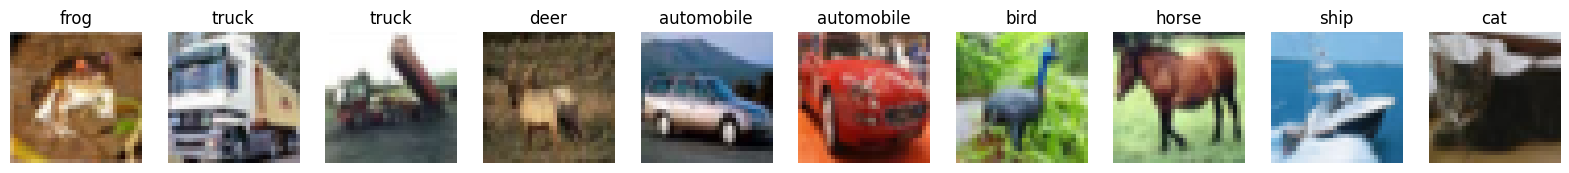

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [3]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images 
images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

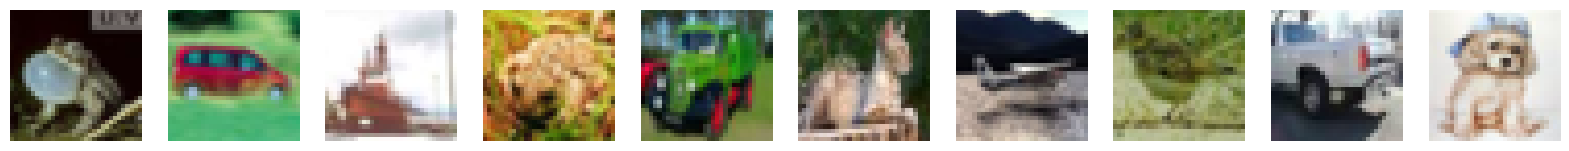

In [4]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

## ResNet Basic Block Implementation

We define a BasicBlock for our ResNet architecture. Each BasicBlock contains two 3×3 convolutional layers followed by batch normalization and ReLU activation. A shortcut connection is added to enable residual learning, with a 1×1 convolution used to match dimensions when necessary.

In our ResNet model, four consecutive blocks with increasing channel sizes (`[64, 128, 256, 512]`) are stacked. We then apply a fixed 4×4 average pooling layer followed by dropout layer (with 50% probability) before the final linear classification layer to increase generalizability. This design was inspired by common practices in CIFAR-10 experiments.

Reference: 'Kuang Liu, "pytorch-cifar," GitHub, 2018, available at: https://github.com/kuangliu/pytorch-cifar'



In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torch
from torchsummary import summary


class BasicBlock(nn.Module):
  def __init__(self, in_channels:int, out_channels: int, kernel: int = 3, stride: int = 1) -> None:
      super(BasicBlock, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel, stride = stride, padding=1,bias = False)
      self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel, stride = 1, padding=1,bias = False)
      self.bn1 = nn.BatchNorm2d(out_channels )
      self.bn2 = nn.BatchNorm2d(out_channels )

      self.shortcut = nn.Sequential()

      if stride != 1 or in_channels != out_channels:
        self.shortcut = nn.Sequential(
            nn.Conv2d(
                in_channels= in_channels,
                out_channels= out_channels,
                stride = stride,
                bias=False,
                kernel_size=1,
            ),
            nn.BatchNorm2d(out_channels)
        )
  def forward(self, x):
      a1 = F.relu(self.bn1(self.conv1(x)))
      a2 = self.bn2(self.conv2(a1))

      out = a2+self.shortcut(x)
      out = F.relu(out)

      return out

In [6]:
class Resnet(nn.Module):
  def __init__(self, out_class: int):
      super(Resnet, self).__init__()
      # self.conv1 = nn.Conv2d(3, out_channels=64, kernel_size=3)
      self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(64)
      
      self.b1 = BasicBlock(64, 64, 3, 1)
      self.b2 = BasicBlock(64, 128, 3, 2)
      self.b3 = BasicBlock(128, 256, 3, 2)
      self.b4 = BasicBlock(256, 512, 3, 2)
      # prev
      # self.mp1 = nn.MaxPool2d(3)
      # prev
      # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      # try
      self.avgpool = nn.AvgPool2d(kernel_size=4)
      self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability
      self.f1 = nn.Flatten()
      self.l1 = nn.Linear(512, out_class)

  def forward(self, x):
      o1 = F.relu(self.bn1(self.conv1(x)))
      o2 = self.b1(o1)
      o3 = self.b2(o2)
      o4 = self.b3(o3)
      o5 = self.f1(self.dropout(self.avgpool(self.b4(o4))))

      return self.l1(o5)


model_DN = Resnet(10).to("cuda")
summary(model_DN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1, 128,

## Data Preparation and Augmentation
We Proceed to prepare CIFAR-10 training data and apply augmentation as follows:

**Data Loading and Preprocessing**:
All five CIFAR-10 training batches are loaded, concatenated, and reshaped into the proper format. The images are converted into PyTorch tensors and normalized.

**Dataset Creation and Splitting**:
Dataset is built using TensorDataset and then split into 90% training and 10% validation subsets

**Data Augmentation**:
For train data, we apply augmentation including random cropping, horizontal flipping, AutoAugment (using the CIFAR-10 policy), and Cutout—followed by normalization. The validation set uses only normalization to maintain data integrity.

**DataLoader Configuration**:
DataLoaders are created for training and validation



data prepared


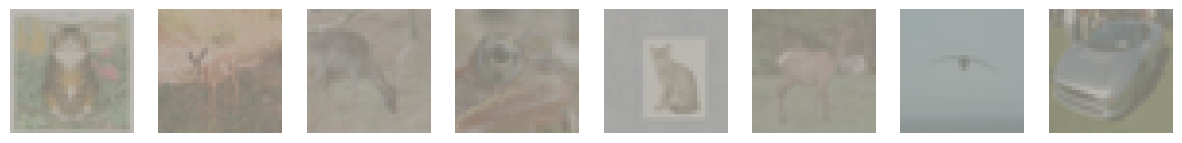

In [15]:
# Prep Data for training
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torch.utils.data import random_split

# ---------------------------
# 1. Load and combine training batches
# ---------------------------
train_images_list = []
train_labels_list = []

for i in range(1, 6):
    batch_file = os.path.join(cifar10_dir, f'data_batch_{i}')
    batch_dict = load_cifar_batch(batch_file)
    train_images_list.append(batch_dict[b'data'])
    train_labels_list.extend(batch_dict[b'labels'])

# Concatenate arrays: resulting shape (50000, 3072)
train_images = np.concatenate(train_images_list, axis=0)
train_labels = np.array(train_labels_list)

# Reshape images to (50000, 3, 32, 32) and then to (50000, 32, 32, 3) for display purposes
train_images = train_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)

# ---------------------------
# 2. Convert to Tensors and Create Full Dataset
# ---------------------------
# Convert training images to torch tensors and adjust dimensions to (N, 3, 32, 32)
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

# Create a TensorDataset for the entire training data
full_dataset = TensorDataset(train_images_tensor, train_labels_tensor)

# ---------------------------
# 3. Split the Dataset into Training and Validation Sets
# ---------------------------
train_size = int(0.9 * len(full_dataset))   # 90% for training
val_size = len(full_dataset) - train_size     # 10% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# ---------------------------
# 4. Data augmentation for training - comment out if it makes test acc worse
'''
Kuang Liu, "pytorch-cifar," GitHub, 2018, available at: https://github.com/kuangliu/pytorch-cifar
Krizhevsky, A., "Learning Multiple Layers of Features from Tiny Images," 2009, available at: http://www.cs.toronto.edu/~kriz/cifar.html
Philip Popien, "AutoAugment", https://github.com/DeepVoltaire/AutoAugment/tree/master?tab=readme-ov-file
'''
# ---------------------------
class Cutout(object):
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)
        mask = np.ones((h, w), np.float32)
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask)
        img = img * mask.unsqueeze(0)
        return img
        
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, fill=128),
    transforms.RandomHorizontalFlip(p=0.5),
    AutoAugment(AutoAugmentPolicy.CIFAR10), 
    transforms.ToTensor(),
    Cutout(n_holes=1, length=16), # (https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py)
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.247, 0.243, 0.261])
])

# For validation, we use only normalization
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.247, 0.243, 0.261])
])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform


# ---------------------------
# 5. Create DataLoaders for Training and Validation
# ---------------------------
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("data prepared")

# Number of images to display
num_images = 8

# Randomly select indices from the training dataset
indices = np.random.choice(len(train_dataset), num_images, replace=False)

# CIFAR-10 normalization parameters (used in our transforms)
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)

plt.figure(figsize=(15, 2))
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = img * std + mean
    # Rearrange dimensions from (C, H, W) to (H, W, C) for display
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    
    plt.subplot(1, num_images, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


## Training The Model

**Optimizer and Scheduler**:
We initialize our ResNet model and use SGD with momentum. (`lr=0.1, momentum=0.9, weight decay=5e-4`)\
Reference: 'Kuang Liu, "pytorch-cifar," GitHub, 2018, available at: https://github.com/kuangliu/pytorch-cifar'

A `CosineAnnealingLR` scheduler is used to gradually decay the learning rate over 80 epochs for smooth convergence.

**Training Loop**:
We implement a loop that updates model parameters using cross-entropy loss on training data and evaluates performance on a separate 10% validation set. Early stopping is applied to halt training if the validation loss starts to plateau, according to the `patience` variable.


Using device: cuda
Epoch [1/80] - Train Loss: 1.66468, Val Loss: 1.40165
Epoch [2/80] - Train Loss: 1.11286, Val Loss: 1.63898
Epoch [3/80] - Train Loss: 0.88123, Val Loss: 0.94350
Epoch [4/80] - Train Loss: 0.74858, Val Loss: 0.87135
Epoch [5/80] - Train Loss: 0.66168, Val Loss: 0.88154
Epoch [6/80] - Train Loss: 0.60241, Val Loss: 0.72198
Epoch [7/80] - Train Loss: 0.56703, Val Loss: 1.01520
Epoch [8/80] - Train Loss: 0.53509, Val Loss: 0.74773
Epoch [9/80] - Train Loss: 0.50500, Val Loss: 0.65043
Epoch [10/80] - Train Loss: 0.48205, Val Loss: 0.92371
Epoch [11/80] - Train Loss: 0.47361, Val Loss: 0.66289
Epoch [12/80] - Train Loss: 0.44584, Val Loss: 0.84337
Epoch [13/80] - Train Loss: 0.43945, Val Loss: 0.73481
Epoch [14/80] - Train Loss: 0.41931, Val Loss: 0.58734
Epoch [15/80] - Train Loss: 0.41829, Val Loss: 0.68237
Epoch [16/80] - Train Loss: 0.39715, Val Loss: 0.77322
Epoch [17/80] - Train Loss: 0.39003, Val Loss: 0.69756
Epoch [18/80] - Train Loss: 0.37791, Val Loss: 0.79342


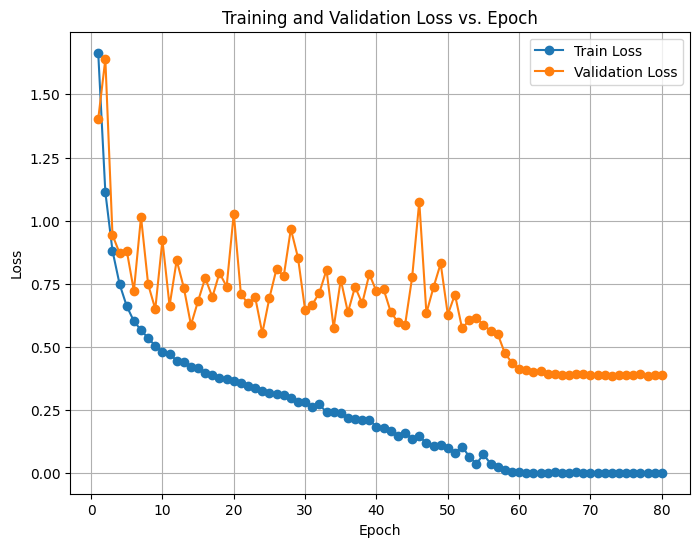

In [13]:
import matplotlib.pyplot as plt

# re-init model for convenience
model_DN = Resnet(10).to("cuda")

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 5. Initialize the Model, Loss, Optimizer, and Scheduler
# ---------------------------
model = model_DN.to(device)
criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)  # https://github.com/kuangliu/pytorch-cifar/blob/master/main.py#L87
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)

# ---------------------------
# 6. Training Loop with Validation and Early Stopping
# ---------------------------
num_epochs = 80
train_epoch_losses = []  # To record training loss per epoch
val_epoch_losses = []    # To record validation loss per epoch

# patience = 15  # (based on validation loss)
# best_val_loss = float('inf')
# patience_counter = 0

for epoch in range(num_epochs):
    # ---- Training Phase ----
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()           # Reset gradients
        outputs = model(images)         # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                 # Backward pass
        optimizer.step()                # Update parameters
        
        running_train_loss += loss.item() * images.size(0)
    
    scheduler.step()  # Adjust the learning rate once per epoch
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_epoch_losses.append(epoch_train_loss)
    
    # ---- Validation Phase ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    epoch_val_loss = running_val_loss / len(val_dataset)
    val_epoch_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.5f}, Val Loss: {epoch_val_loss:.5f}")
    
    # Early stopping logic based on validation loss
    # if epoch_val_loss < best_val_loss:
    #     best_val_loss = epoch_val_loss
    #     patience_counter = 0  # Reset counter if improvement is seen
    # else:
    #     patience_counter += 1
    #     print(f"No improvement for {patience_counter} epoch(s).")
    #     if patience_counter >= patience:
    #         print("Early stopping triggered.")
    #         break

print("Training complete.")

# Plot training and validation loss vs. epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_epoch_losses)+1), train_epoch_losses, marker='o', label="Train Loss")
plt.plot(range(1, len(val_epoch_losses)+1), val_epoch_losses, marker='o', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

In [16]:
# Load test batch
test_batch_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
test_images = test_batch_dict[b'data']
test_labels = test_batch_dict[b'labels']

# Reshape test images from (10000, 3072) to (10000, 3, 32, 32) 
# and then convert them to (10000, 32, 32, 3) if needed
test_images = test_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Convert test images to torch tensors and rearrange dimensions to (N, 3, 32, 32)
# Here, we convert to tensor and then permute back to (N, 3, 32, 32)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
print("Test images tensor shape:", test_images_tensor.shape)

# Convert test labels to a torch tensor
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
print("Test labels tensor shape:", test_labels_tensor.shape)

# Create a TensorDataset and DataLoader for the test set
from torch.utils.data import TensorDataset, DataLoader
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()

test_accuracy = correct / total
print("Test Accuracy:", test_accuracy)

# Count the number of trainable parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters in the model:", num_params)

Test images tensor shape: torch.Size([10000, 3, 32, 32])
Test labels tensor shape: torch.Size([10000])
Test Accuracy: 0.8727
Number of parameters in the model: 4903242
